In [260]:
import IPython
IPython.display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code"></form>''')

In [49]:
%%capture
# Load scripts
import pandas as pd
import os, requests, json
import numpy as np
from clustergrammer_widget import *
os.chdir('/Users/denis/Documents/Projects/hiv-analysis/hiv-signature-analysis')
%load_ext rpy2.ipython
%R source('/Users/denis/Documents/Projects/scripts/Support.R')
%R library(ggplot2)
%R library(reshape2);

In [222]:
# Infiles
expressionFile = 'f2-normalized_expression_data.dir/podocyte_cell_line-vst.txt'
correctedExpressionFile = 'f3-adjusted_expression_data.dir/podocyte_cell_line-vst_corrected.txt'
annotationFile = 'rawdata.dir/hiv_sample_annotation.txt'
cdFile = 'f4-differential_expression.dir/podocyte_cell_line-vst_corrected-differential_expression.txt'
enrichmentFile = 'f5-geneset_enrichment.dir/podocyte_cell_line-vst_corrected-differential_expression_geneset_enrichment.txt'
enrichmentLinkFile = 'f5-geneset_enrichment.dir/podocyte_cell_line-vst_corrected-differential_expression_geneset_ids.txt'
l1000cds2File = 'f6-l1000cds2_analysis.dir/podocyte_cell_line-vst_corrected-differential_expression_l1000cds2_results.txt'
l1000cds2LinkFile = 'f6-l1000cds2_analysis.dir/podocyte_cell_line-vst_corrected-differential_expression_l1000cds2_links.txt'
clustergrammerFile = 'f7-clustergrammer.dir/podocyte_cell_line-vst_corrected-clustergrammer_input.txt'

# Read data
expressionDataframe = pd.read_table(expressionFile).set_index('gene_symbol')
correctedExpressionDataframe = pd.read_table(correctedExpressionFile).set_index('gene_symbol')
annotationDataframe = pd.read_table(annotationFile).set_index('cell_type').loc['cell_line',:].T.dropna().T.set_index('sample_name').astype('str')
cdDataframe = pd.read_table(cdFile).set_index('gene_symbol')
enrichmentDataframe = pd.read_table(enrichmentFile)
enrichmentLinkDataframe = pd.read_table(enrichmentLinkFile)
l1000cds2Dataframe = pd.read_table(l1000cds2File).drop('drugbank_id', 1)
l1000cds2Dataframe['perturbation'] = l1000cds2Dataframe['perturbation'].astype('str')
l1000cds2LinkDataframe = pd.read_table(l1000cds2LinkFile)

# Import to R
%R -i expressionDataframe,correctedExpressionDataframe,annotationDataframe,cdDataframe,enrichmentDataframe,l1000cds2Dataframe

In [251]:
# Enrichment processing
# Fix timepoints
enrichmentDataframe['timepoint'] = [x.replace('h','')+'h' for x in enrichmentDataframe['timepoint']]
enrichmentLinkDataframe['timepoint'] = [x.replace('h','')+'h' for x in enrichmentLinkDataframe['timepoint']]
l1000cds2LinkDataframe['timepoint'] = [x.replace('h','')+'h' for x in l1000cds2LinkDataframe['timepoint']]

# Define dictionary
enrichmentData = {}

# Add data
for direction in ['upregulated', 'downregulated']:
    enrichmentDataframeSubset = enrichmentDataframe.loc[enrichmentDataframe['direction'] == direction, :]
    enrichmentDataframeCast = enrichmentDataframeSubset.pivot(index='term_name', columns='timepoint', values='combined_score').fillna(0).loc[:,['6h','12h','24h','48h']]
    sortedTerms = enrichmentDataframeCast.apply(sum, 1).sort_values(ascending=False).index
    enrichmentData[direction] = enrichmentDataframeCast.loc[sortedTerms, :]
    
upregulatedEnrichmentData = enrichmentData['upregulated']
downregulatedEnrichmentData = enrichmentData['downregulated']

# Enrichment data
significanceData = {}

# Add data
for direction in ['upregulated', 'downregulated']:
    enrichmentDataframeSubset = enrichmentDataframe.loc[enrichmentDataframe['direction'] == direction, :]
    enrichmentDataframeCast = enrichmentDataframeSubset.pivot(index='term_name', columns='timepoint', values='FDR').fillna(1).loc[:,['6h','12h','24h','48h']]
    sortedTerms = enrichmentDataframeCast.apply(sum, 1).sort_values(ascending=False).index
    significanceData[direction] = enrichmentDataframeCast.loc[sortedTerms, :]
    
upregulatedSignificanceData = significanceData['upregulated']
downregulatedSignificanceData = significanceData['downregulated']

# Import to R
%R -i upregulatedEnrichmentData,downregulatedEnrichmentData,upregulatedSignificanceData,downregulatedSignificanceData

# Analysis of the effect of HIV infection in patient-derived podocyte cell lines
## Background
#### Nephropathy
Nephropathy, also known as kidney or renal disease, is a general term referring to any damage that reduces the functioning of the kidney.  The kidneys are a pair of fist-sized organs located below the rib cage; their key functions include filtering the blood to remove waste products resulting from normal tissue activity in the body, and regulating the amount of water and electrolytes in the body.  As the kidney has many functions, there are multiple types of kidney diseases.  These include acute and chronic, inflammatory (nephritis) and noninflammatory (nephrosis), and often lead to kidney failure to more or less degree.

#### HIVAN
HIV-Associated Nephropathy (HIVAN) is a form of kidney disease which arises in association with human immunodeficiency virus (HIV) infection.  HIVAN can arise as various types of kidney diseases, with the most common being focal segmental glomerulosclerosis (FSGS).  The disease can be caused in a variety of ways: as a result of direct infection of kidneys by HIV, following renal damage induced by viral gene products, or by effect of altered cytokine release induced during HIV infection.

In the USA, 12% of patients dying with AIDS have histologically proven HIVAN; it is estimated that the worldwide incidence follows similar trends.  Renal disease in HIV-positive patients is generally associated with an increased risk of death.

#### Podocytes
Podocytes are elongated, foot-like epithelial cells located within the Bowman's capsule of the kidneys.  These cells have major processes, each supporting a series of minor processes, which wrap around capillaries and interweave with those from other podocytes to form a number of slits.  These slits (approximately 0.1 μm wide) allow the filtration of blood by permitting the passage of most plasma constituents, while acting as a barrier to blood cells.
## Overview
#### Data
The data analyzed in this report was generated in the lab of Dr. Paul Klotman and provided by Dr. Weijia Zhang.
Here is an overview of the data:
- The dataset comprises of transcriptomics data obtained by* RNA-sequencing* of HIV-infected cell lines.
- The cell lines were generated from *patient-derived podocytes* in the Klotman lab.
- HIV infection was performed at *multiple timepoints*: 6h, 12h, 24h, 48h.  Controls are labeled as 0h.
- Samples are divided in *three batches*: batch 2, batch 3, batch 4.  Each batch has at least one replicate of each timepoint, and at least one control.
- Sample names are annotated in the following way: '*h{timepoint}.{batch}*'  e.g. h6.2 (6h infection, batch 2).

#### Analysis
The analysis aims at investigating the effects of HIV infection on podocyte gene expression across multiple timepoints.  Specifically, the analysis addresses the following questions:
1. Do samples infected by HIV at similar timepoints have similar gene expression profiles? 
2. Which pathways are most dysregulated by the HIV infection at different timepoints?
3. What are the small molecules which most strongly mimic and reverse the gene expression signatures generated by HIV infection?

## Results

## 1. Exploratory Data Analysis
The first part of the analysis aims to investigate how samples from similar HIV infection timepoints separate based on their gene expression profiles.

#### 1.1 PCA Analysis of Data
In order to assess the separation of samples based on their gene expression profiles, an unsupervised PCA was performed on the data.

In [24]:
%%R
plotPCA <- function(expressionDataframe, sampleLabels, main='', legendTitle = '', PCs=c('PC1', 'PC2'))
{
    # Run PCA
    pcaRes <- runPCA(expressionDataframe)

    # Get plot matrix
    plotMatrix <- pcaRes$x

    # Get color legend
    sampleNames <- rownames(plotMatrix)
    colorLegend <- getLegend(sampleNames, sampleLabels)#, colors=c('black','red','blue'))

    # Plot
    plot(plotMatrix[,PCs],
         col=colorLegend$colors,
         xlab=pcaRes$varLabels[PCs[1]],
         ylab=pcaRes$varLabels[PCs[2]],
         main=main)

    # Legend
    legend('topright', legend=names(colorLegend$legend), fill=colorLegend$legend, title=legendTitle)
}

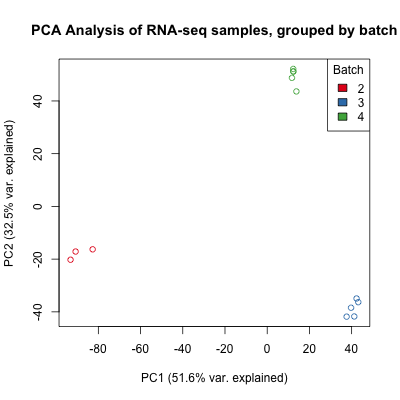

In [265]:
%%R -h 400 -w 400
# Plot
plotPCA(expressionDataframe, as.numeric(annotationDataframe[colnames(expressionDataframe), 'batch'])+1, 'PCA Analysis of RNA-seq samples, grouped by batch', 'Batch')

*Figure 1A*.  PCA analysis of the dataset.  The plot shows that the data is affected by significant batch effects, whereby a large fraction of the variance is explained by the batch from which the samples originate - rather than by the HIV treatment or by the timepoint of infection.

#### 1.2  Batch Effect Removal
In order to address this issue, the batch effect removal algorithm ComBat (Leek JT et al., 2016) was used.  This algorithm employs Surrogate Variable Analysis (SVA), a method which allows the extraction of covariates from high-dimensional data (known surrogate variables) that can be used in subsequent analyses to adjust for latent sources of noise.  The PCA analysis was then repeated on the corrected data.

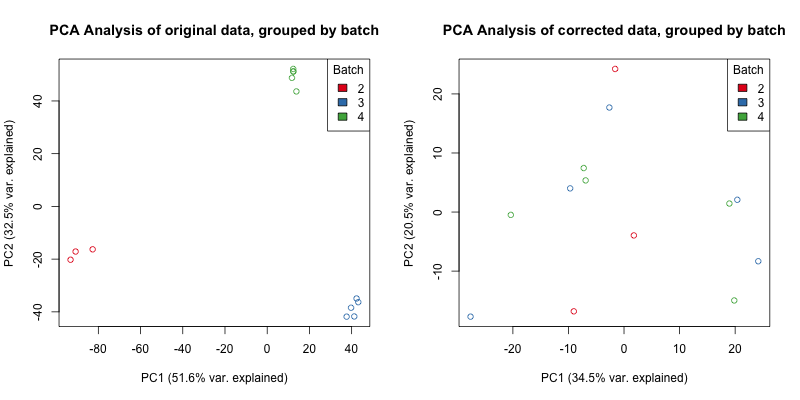

In [266]:
%%R -h 400 -w 800
# Plot
par(mfrow=c(1,2))
plotPCA(expressionDataframe, as.numeric(annotationDataframe[colnames(expressionDataframe), 'batch'])+1, 'PCA Analysis of original data, grouped by batch', 'Batch')
plotPCA(correctedExpressionDataframe, as.numeric(annotationDataframe[colnames(expressionDataframe), 'batch'])+1, 'PCA Analysis of corrected data, grouped by batch', 'Batch')

*Figure 1B*. PCA analysis of original and batch effect-corrected datasets. The plot shows that the ComBat algorithm effectively removes the batch effect from the data, while highlighting similarity between samples infected at similar timepoints.
#### 1.3 Heatmap Visualization
To allow better visualization of the dataset, an interactive heatmap was generated with the Clustergrammer tool.

In [267]:
# Initialize network object
net = Network()

# load matrix file
net.load_file(clustergrammerFile)

# cluster using default parameters
net.make_clust()

# make interactive widget
clustergrammer_widget(network=net.widget())

*Figure 1C*.  Interactive visualization of the dataset.  Rows represent the 1000 most variable genes in the data, columns represent samples, and the color bars represent the different timepoints and batches associated to each sample.  Values show normalized expression levels.
## 2. Differential Expression and Enrichment Analysis
The second part of the analysis aims to investigate the differential gene expression signatures associated to HIV treatment at different timepoints, including enrichment analysis to identify biological pathways and terms associated to the most strongly dysregulated genes.
#### 2.1 Extraction of Differential Gene Expression Signatures
In order to identify differentially expressed genes, a differential gene expression analysis was performed by comparing the gene expression levels at different HIV infection timepoints to the ones of the uninfected controls with the Characteristic Direction (CD) algorithm (Clark et al., 2014).  The algorithm employs a multivariate approach to the identification of differential gene expression by using linear classification methods.

The following plot shows the relationship between the CD values of genes at different timepoints, compared to the uninfected controls.

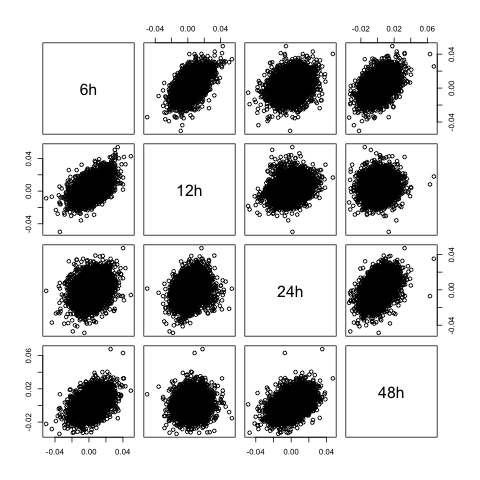

In [278]:
%%R
colnames(cdDataframe) <- paste0(gsub('h','', colnames(cdDataframe)), 'h')
plot(cdDataframe)

*Figure 2A*.  Relationship between Characteristic Direction (CD) values of genes across multiple timepoints.  Axes represent CD values calculated as explained above.  The plot reveals that the 6h and 12h timepoints are more similar to each other when compared to other timepoints; correlation of CD values is otherwise generally poor.
#### 2.2 Geneset Enrichment Analysis
In order to investigate the enrichment of the genes which are dysregulated by HIV infection, a geneset enrichment analysis was performed on the top 500 most upregulated and downregulated genes at each timepoint using Enrichr (Chen et al., 2013).  The tool calculates the enrichment of genesets across a large number of libraries associated to biological pathways, transcriptional factor targets, diseases, and many other relevant terms.

In [63]:
%%R
plot_enrichment <- function(enrichmentDataframe, significanceDataframe, direction, termName, main=NULL, mar=c(5,4,7,2)) {
    
    # Set margins
    par(mar=mar)
    
    # Fix colnames
    colnames(enrichmentDataframe) <- gsub('X', '', colnames(enrichmentDataframe))
    
    # Get plot dataframe
    barpos <- barplot(rev(as.numeric(enrichmentDataframe[termName,])),
                  names.arg=rev(colnames(enrichmentDataframe)),
                  main = main,
                  xlab = 'Enrichment Score',
                  ylab = 'Timepoint',
                  las = 2,
                  horiz = TRUE,
                  col = ifelse(direction=='upregulated', 'red3', 'navyblue'))
    
    # Add term
    mtext(gsub('(', '\n(', termName, fixed=TRUE)[[1]][1], padj=-0.2, cex=0.8)
    
    # Add text
    pvalueLabels <- paste0('q=', format.pval(rev(as.numeric(significanceDataframe[termName,])), digits=1))
    pvalueLabels <- sapply(rev(significanceDataframe[termName,]), function(x) ifelse(x <= 0.1, paste0('q=', format.pval(x, digits=1)), ''))
    text(x=0, y=barpos, labels=pvalueLabels, pos=4, offset=0.5, col='white', cex=1.2)
}

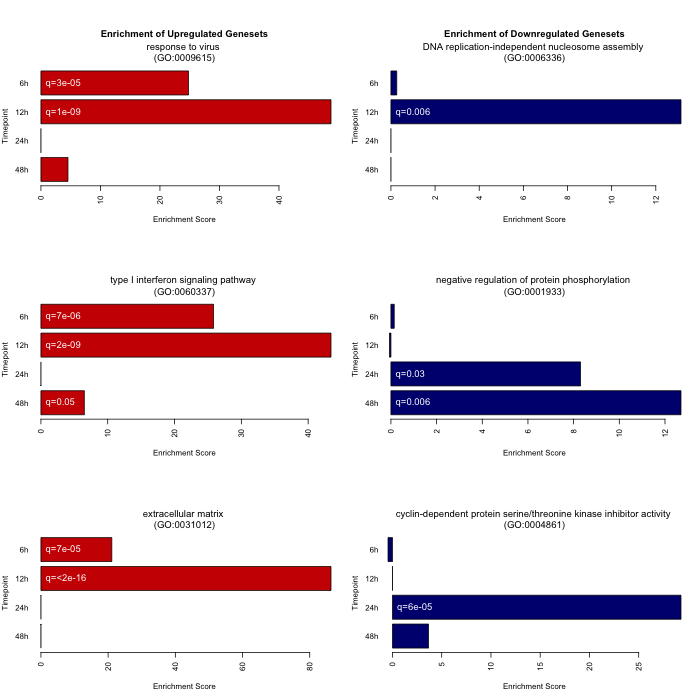

In [65]:
%%R -h 700 -w 700
par(mfrow=c(3,2))
plot_enrichment(upregulatedEnrichmentData, upregulatedSignificanceData, 'upregulated', termName='response to virus (GO:0009615)', main='Enrichment of Upregulated Genesets')
plot_enrichment(downregulatedEnrichmentData, downregulatedSignificanceData, 'downregulated', termName='DNA replication-independent nucleosome assembly (GO:0006336)', main='Enrichment of Downregulated Genesets')
plot_enrichment(upregulatedEnrichmentData, upregulatedSignificanceData, 'upregulated', termName='type I interferon signaling pathway (GO:0060337)')
plot_enrichment(downregulatedEnrichmentData, downregulatedSignificanceData, 'downregulated', termName='negative regulation of protein phosphorylation (GO:0001933)')
plot_enrichment(upregulatedEnrichmentData, upregulatedSignificanceData, 'upregulated', termName='extracellular matrix (GO:0031012)')
plot_enrichment(downregulatedEnrichmentData, downregulatedSignificanceData, 'downregulated', termName='cyclin-dependent protein serine/threonine kinase inhibitor activity (GO:0004861)')

*Figure 2B*.  Enrichment scores and q-values of selected GO terms in the upregulated and downregulated genesets across different timepoints.

The data reveals some interesting information:
- Early timepoints of HIV infection (6h and 12h) show a significant upregulation in the expression of genes involved in virus response, with a peak at 12 hours.
- The 12 hour timepoint also shows a significant downregulation of genes involved in DNA replication-independent nucleosome assembly.  This observation might be somehow related to the process of viral genome replication taking place in cells, though the interpretation of this connection is still unclear.
- Early timepoints also show upregulation of genes involved in type I interferon signaling, a pathway involved in the response of pathogens such as viruses and bacteria; and genes involved in the extracellular matrix.
- Later timepoints of infection (24h and 48h) show a downregulation of genes involved in the inhibition of phosphorylation and inhibition CDK activity.  This could possibly indicate that cells are inactivating a number of proliferation-inhibitory pathways, thus allowing the progression of cell cycle, but the interpretation is unclear.  

#### 2.3 Links to Enrichr Results
For a more complete view of the enrichment results, links to the Enrichr results pages are available in the table below:

In [193]:
pd.set_option('display.max_colwidth', -1)
enrichmentLinkDataframe.pivot(index='timepoint', columns='direction', values='URL').loc[['6h','12h','24h','48h']]

direction,downregulated,upregulated
timepoint,,
6h,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=18zzb,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=18zz7
12h,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=18zza,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=18zz6
24h,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=18zz9,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=18zz5
48h,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=18zzc,http://amp.pharm.mssm.edu/Enrichr/enrich?dataset=18zz8


## 3. Analysis of Small Molecules
The third and final part of the analysis aims to determine whether there are any small molecules which significantly and reproducibly mimic or reverse the gene expression signatures generated by HIV infection, when used for treatment on cell lines.

#### 3.1 L1000CDS<sup>2</sup> Analysis
In order to identify gene expression signatures which mimic or reverse the observed signatures, a signature search was performed by using the L1000CDS<sup>2</sup> tool (Duan et al., 2016).  The tool compares the input signatures with the LINCS L1000 library of gene signatures by using the cosine distance, returning the top similar or opposite signatures.

In [281]:
%%R
plotTopMolecules <- function(l1000cds2Dataframe, type, nDrugs=5) {
    
    # Replace long names
    l1000cds2Dataframe$perturbation <- gsub('Hydrate', '\nHydrate', l1000cds2Dataframe$perturbation)
    
    # Get counts
    drugTimepointCounts <- table(l1000cds2Dataframe$perturbation, l1000cds2Dataframe$timepoint)

    # Get sorted by sum
    topDrugs <- rev(names(sort(apply(drugTimepointCounts, 1, sum), decreasing=TRUE))[1:nDrugs])

    # Get plot matrix
    plotMatrix <- t(drugTimepointCounts[topDrugs,c('h6','h12','h24','h48')])

    # Set margins
    par(mar=c(6,10,2,4))

    # Set colors
    colors <- c('6h'='#ffffb2','12h'='#fecc5c','24h'='#fd8d3c','48h'='#e31a1c')

    # Plot
    barplot(plotMatrix, horiz=TRUE, las=2, xlab='Times associated to top 50 signatures', ylab='Small molecule\n\n\n\n\n', main=paste0('Top ', nDrugs,' small molecules which ', type, ' HIV signature'), col=colors)

    # Legend
    legend('bottomright', fill=colors, legend=names(colors), title='Timepoint')
}

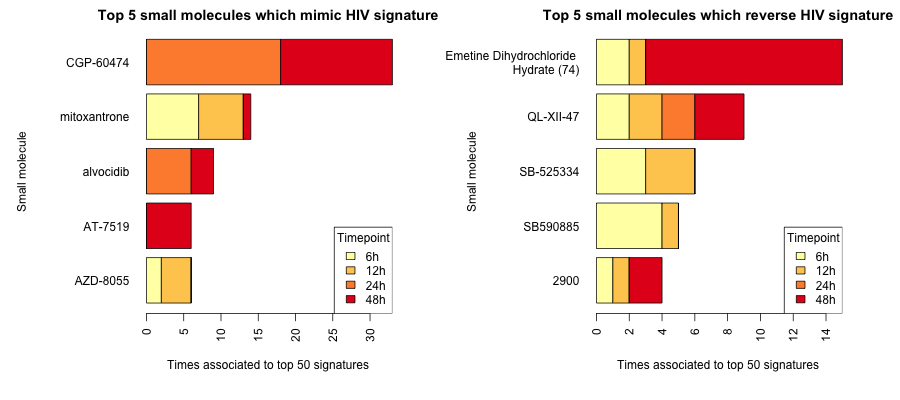

In [282]:
%%R -h 400 -w 900
# Split dataframes
l1000cds2DataframeMimic <- l1000cds2Dataframe[l1000cds2Dataframe$aggravate,]
l1000cds2DataframeReverse <- l1000cds2Dataframe[!l1000cds2Dataframe$aggravate,]

# Plot
par(mfrow=c(1,2))
plotTopMolecules(l1000cds2DataframeMimic, 'mimic')
plotTopMolecules(l1000cds2DataframeReverse, 'reverse')

*Figure 3A*.  Barplot of the small molecules which reproducibly mimic or reverse HIV gene expression signatures in independent experiments.  For each HIV timepoint, L1000cds<sup>2</sup> was used to identify the top 50 most similar (or dissimilar) gene expression signatures.  The X axis of the barplot displays how many of these signatures were generated using the corresponding drug, for each timepoint. 

The analysis highlights a series of known and novel small molecules, some of which are reported to play a key role in viral replication:

- ***Molecules which mimic HIV signature ***
    - **CGP-60474**, a dual CDK1/2 inhibitor which displays reversible G<sub>1</sub>/S cell cycle arrest.  It stongly mimics human kidney disease signatures in 3 different cell lines, according to a GEN3VA report on diabetic nephropathy.
    - **Mitoxantrone**, an antineoplastic agent used to treat prostate cancer and certain types of leukemia, as well as multiple sclerosis.
    
    
- ***Molecules which reverse HIV signature***

    - **Emetine Dihydrochloride Hydrate**, a natural plant alkaloid.  Its original form has been reported to inhibit HIV-1 replication by interfering with reverse transcriptase activity (Chaves Valvadao et al., 2015).
    - **QL-XII-47**, a quinolone antibiotic.  It has been reported to display borad-spectrum antiviral activity against dengue virus and other RNA viruses (Liang et al., 2017).

#### 3.2 Publications Associated to Relevant Small Molecules
Snippets of websites relevant to some of these drugs are available below:

##### Emetine

In [269]:
IPython.display.HTML('<iframe src=' + 'https://www.ncbi.nlm.nih.gov/pubmed/26111177' + ' width=950 height=350></iframe>')

#### QL-XIIl47

In [277]:
IPython.display.HTML('<iframe src=' + 'http://grantome.com/grant/NIH/U54-AI057159-09-6104' + ' width=950 height=350></iframe>')

#### 3.3 Links to L1000CDS<sup>2</sup> Results
For a more complete view of the results, links to the L1000CDS<sup>2</sup> results pages are available in the table below:

In [253]:
l1000cds2LinkDataframe.set_index('timepoint').loc[['6h','12h','24h','48h']]

,reverse,mimic
timepoint,,
6h,http://amp.pharm.mssm.edu/L1000CDS2/#/result/58a1e72ee467bea600fb654c,http://amp.pharm.mssm.edu/L1000CDS2/#/result/58a1e729e467bea600fb654a
12h,http://amp.pharm.mssm.edu/L1000CDS2/#/result/58a1e735e467bea600fb6550,http://amp.pharm.mssm.edu/L1000CDS2/#/result/58a1e732e467bea600fb654e
24h,http://amp.pharm.mssm.edu/L1000CDS2/#/result/58a1e73ce467bea600fb6554,http://amp.pharm.mssm.edu/L1000CDS2/#/result/58a1e739e467bea600fb6552
48h,http://amp.pharm.mssm.edu/L1000CDS2/#/result/58a1e744e467bea600fb6558,http://amp.pharm.mssm.edu/L1000CDS2/#/result/58a1e740e467bea600fb6556
